We want to find out A of wave equation


$$\frac{1}{v^2} \frac{\delta^2 y}{\delta t^2}- \frac{\delta ^2}{\delta x^2}= 0$$

In [29]:

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from math import exp
import functools

import torch 
from torch import nn, optim
from torch.nn import functional as F

from sklearn.model_selection import train_test_split



# Define the domain
boundaries = (-1,1)     # boundary values of x
T = 3                   # Time duration
num_samples = 10000     # Number of samples

# Generate random sample points
x_samples = np.random.uniform(boundaries[0], boundaries[1], num_samples)
t_samples = np.random.uniform(0, T, num_samples)

# Compute the wave function values (assuming a known solution)
# For demonstration, let's use a simple sinusoidal wave solution
# u(x, t) = A * sin(k * x - omega * t)
A = 1        # Amplitude
k = 2 * np.pi   # Wave number
omega = 2 * np.pi  # Angular frequency

u_samples = A * np.sin(k * x_samples - omega * t_samples)

# Feature-set and target-set
features = np.column_stack((x_samples, t_samples))
targets = u_samples

# plt.figure(figsize=(14, 6), dpi=100)
# plt.scatter(features[:, 0], features[:, 1], c=targets, s=20, cmap='viridis')
# plt.colorbar()


In [2]:
class Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64, n_layers=2):
        
        super(Net, self).__init__()
        
        # model discovery parameters
        #self.A = nn.Parameter(data=torch.tensor(0.), requires_grad=True) # rate of temp change. Init=0.
        
        activation = nn.Softplus # nn.LeakyReLU, nn.Tanh, nn.ReLU, nn.ELU

        self.input = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), 
            activation()
        )
        
        self.network = nn.Sequential(
            *[nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                activation()
            ) for i in range(n_layers)]
        )

        self.output = nn.Sequential(
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x = self.input(x)
        x = self.network(x)
        x = self.output(x)
        return x


In [3]:
def gradient(outputs, inputs, order=1):
    """
    Computes the partial derivative of 
    an output with respect to an input.
    Given an order, we compute the gradient multiple times.
    """
    grads = []
    for i in range(order):
        grads.append(torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0])
        outputs = grads[-1]
    
    return outputs, grads



In [75]:
A, v = 2, 4


def initial_condition_1(model: nn.Module, features):
    # Gaussian source
    
    x0 = 0 # positions of the source
    sigma0 = 0.3 # width of the frequency 

    x = features[:, 0]
    t = torch.zeros_like(x, requires_grad=True)
    coll_points = torch.column_stack((x, t))

    pressure0 = torch.exp(-((x - x0)/sigma0)**2)
    pred_pressure0 = model(coll_points)

    return torch.mean(pressure0 - pred_pressure0)**2


def initial_condition_2(model: nn.Module, features):
    # v = 0 for t = 0 

    x = features[:, 0]
    t = torch.zeros_like(x, requires_grad=True)
    coll_points = torch.column_stack((x, t))

    pred_pressure0 = model(coll_points)
    pred_pressure0_grad, _ = gradient(pred_pressure0, t)

    return torch.mean(pred_pressure0_grad)**2


def boundary_condition(model: nn.Module, features, boundaries: tuple):
    # boundary domain is in 'x'
    neg_bc, pos_bc = boundaries
    t = features[:, 1]
    x_neg_bc = torch.ones(len(t), dtype=torch.float32, requires_grad=True)*neg_bc
    x_pos_bc = torch.ones(len(t), dtype=torch.float32, requires_grad=True)*pos_bc

    # concat the boundary values to the time values
    neg_boundary = torch.column_stack((x_neg_bc, t))
    pos_boundary = torch.column_stack((x_pos_bc, t))

    neg_pred = model(neg_boundary)
    pos_pred = model(pos_boundary)
    
    neg_pred_grad, _ = gradient(neg_pred, neg_boundary)
    pos_pred_grad, _ = gradient(pos_pred, pos_boundary)
    
    loss = torch.mean(neg_pred_grad**2 + pos_pred_grad**2)

    return loss


def pde_loss(prediction: torch.tensor, features, v):
    """
    1/v^2 * u_tt - u_xx = 0
    """
    u_grad_grad, _ = gradient(prediction, features, order=2)
    u_tt = u_grad_grad[:, 1]
    u_xx = u_grad_grad[:, 0]

    #compute the loss
    model_pde = (1/(v**2) * u_tt - u_xx)
    loss = torch.mean((model_pde)**2)

    return loss



In [76]:
from softadapt import LossWeightedSoftAdapt

features_ = torch.tensor(features, dtype=torch.float32, requires_grad=True).reshape(-1, 2)
targets_ = torch.tensor(targets, dtype=torch.float32, requires_grad=True).reshape(-1, 1)

print(features_.shape, type(features_))
print(targets_.shape)



torch.Size([10000, 2]) <class 'torch.Tensor'>
torch.Size([10000, 1])


Epoch 100/10000, Loss: 0.0012999566593073198
Epoch 199/10000, Loss: 0.00036887265184886196
Epoch 298/10000, Loss: 0.0001013462767401037
Epoch 397/10000, Loss: 2.3888666609167567e-05
Epoch 496/10000, Loss: 8.812356496553633e-06
Epoch 595/10000, Loss: 5.578404689993978e-06
Epoch 694/10000, Loss: 3.881245858706697e-06
Epoch 793/10000, Loss: 2.608280891699076e-06
Epoch 892/10000, Loss: 1.7262008966855099e-06
Epoch 991/10000, Loss: 1.177677434587167e-06
Epoch 1090/10000, Loss: 8.678678240045185e-07
Epoch 1189/10000, Loss: 6.988807496784943e-07
Epoch 1288/10000, Loss: 6.035366613076872e-07
Epoch 1387/10000, Loss: 5.416483225786835e-07
Epoch 1486/10000, Loss: 4.9402779916005e-07
Epoch 1585/10000, Loss: 4.521650768739688e-07
Epoch 1684/10000, Loss: 4.1378889032455756e-07
Epoch 1783/10000, Loss: 3.775461268559287e-07
Epoch 1882/10000, Loss: 3.4325270769205295e-07
Epoch 1981/10000, Loss: 3.1107053021463117e-07
Epoch 2080/10000, Loss: 2.8096570720815623e-07
Epoch 2179/10000, Loss: 2.5317521587848

KeyboardInterrupt: 

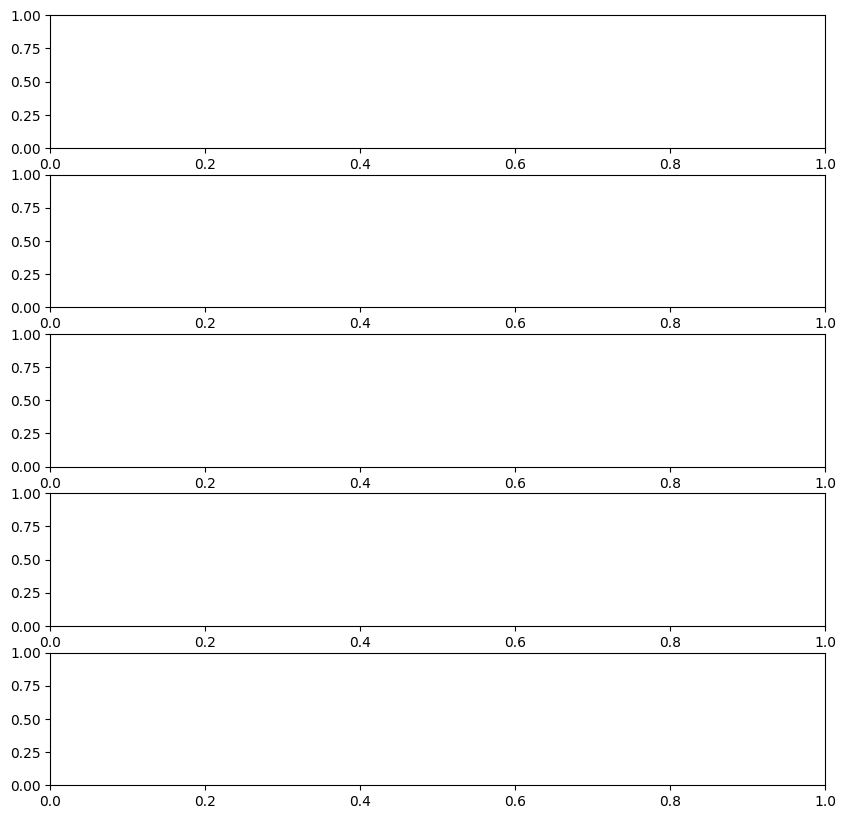

In [79]:
# defining model
pinn = Net(input_dim=2, output_dim=1, hidden_dim=8, n_layers=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(pinn.parameters(), lr=1e-3, weight_decay=1e-5)


### SoftAdapt parameters
# Change 1: Create a SoftAdapt object (with your desired variant)
softadapt_object = LossWeightedSoftAdapt(beta=0.1)

# Change 2: Define how often SoftAdapt calculate weights for the loss components
epochs_to_make_updates = 5

# Change 3: Initialize lists to keep track of loss values over the epochs we defined above
values_comp1 = []
values_comp2 = []
values_comp3 = []
values_comp4 = []

# Initializing adaptive weights to all ones.
adapt_weights = torch.tensor([1,1,1,1])


### training loop
epochs = 10000

# Prepare the plot
fig, ax = plt.subplots(figsize=(10, 10), nrows=5)

losses = np.zeros(epochs)
losses_pde = np.zeros(epochs)
losses_ic1 = np.zeros(epochs)
losses_ic2 = np.zeros(epochs)
losses_bc = np.zeros(epochs)

lambda_pde = np.zeros(epochs)
lambda_ic1 = np.zeros(epochs)
lambda_ic2 = np.zeros(epochs)
lambda_bc = np.zeros(epochs)

epochs_x = np.arange(epochs)

verbose = False
pinn.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    
    u_pred = pinn(features_)

    # PDE physics loss
    loss_pde = pde_loss(u_pred, features_, v=v)

    # IC physics loss
    loss_ic1 = initial_condition_1(pinn, features_)
    loss_ic2 = initial_condition_2(pinn, features_)

    # BC physics loss
    loss_bc = boundary_condition(pinn, features_, boundaries=boundaries)

    
    values_comp1.append(loss_pde)
    values_comp2.append(loss_ic1)
    values_comp3.append(loss_ic2)
    values_comp4.append(loss_bc)
    
    # Change 4: Make sure `epochs_to_make_change` have passed before calling SoftAdapt.
    if epoch % epochs_to_make_updates == 0 and epoch != 0:
        adapt_weights = softadapt_object.get_component_weights(torch.tensor(values_comp1), 
                                                                torch.tensor(values_comp2),
                                                                torch.tensor(values_comp3),
                                                                torch.tensor(values_comp4),
                                                                verbose=False,
                                                                )
                                
        # Resetting the lists to start fresh (this part is optional)
        values_comp1 = []
        values_comp2 = []
        values_comp3 = []
        values_comp4 = []
    
    # Change 5: Update the loss function with the linear combination of all components.
    loss = adapt_weights[0] * loss_pde + adapt_weights[1]*loss_ic1 + adapt_weights[2]*loss_ic2 + adapt_weights[3]*loss_bc
    

    loss.backward()         # Backward pass: Compute gradient of the loss with respect to model parameters
    optimizer.step()        # Update weights
    
    # logging
    losses[epoch] = loss.item()
    losses_pde[epoch] = loss_pde.item()
    losses_ic1[epoch] = loss_ic1.item()
    losses_ic2[epoch] = loss_ic2.item()
    losses_bc[epoch] = loss_bc.item()

    lambda_pde[epoch] = adapt_weights[0]
    lambda_ic1[epoch] = adapt_weights[1]
    lambda_ic2[epoch] = adapt_weights[2]
    lambda_bc[epoch] = adapt_weights[3]

    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}') if epoch % 99 == 0 and epoch != 0 else None
    


    if epoch % 999 == 0 and epoch != 0 and verbose:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

        # Plotting the loss
        ax[0].plot(epochs_x[:epoch], losses[:epoch], 'b')
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Loss')
        ax[0].set_title('Training Loss')
        ax[0].set_xlim(0, epochs)

        ### Plotting the loss components
        ax[1].plot(epochs_x[:epoch], losses_pde[:epoch], 'b', label='PDE Loss')
        ax[1].plot(epochs_x[:epoch], losses_ic1[:epoch], 'r', label='IC Loss 1')
        ax[1].plot(epochs_x[:epoch], losses_ic2[:epoch], 'g', label='IC Loss 2')
        ax[1].plot(epochs_x[:epoch], losses_bc[:epoch], 'y', label='BC Loss')
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('Loss')
        ax[1].set_title('Component losses')
        ax[1].set_xlim(0, epochs)
        ax[1].set_yscale("log")

        ### Plotting the weights
        ax[2].plot(epochs_x[:epoch], lambda_pde[:epoch], 'b', label='PDE Loss')
        ax[2].plot(epochs_x[:epoch], lambda_ic1[:epoch], 'r', label='IC Loss 1')
        ax[2].plot(epochs_x[:epoch], lambda_ic2[:epoch], 'g', label='IC Loss 2')
        ax[2].plot(epochs_x[:epoch], lambda_bc[:epoch], 'y', label='BC Loss')
        ax[2].set_xlabel('Epochs')
        ax[2].set_ylabel('$\lambda$')
        ax[2].set_title('Component weights')
        ax[2].set_xlim(0, epochs)


        display.clear_output(wait=True)
        display.display(fig)
        
        # Pause a bit so that the plot updates
        plt.pause(0.1)



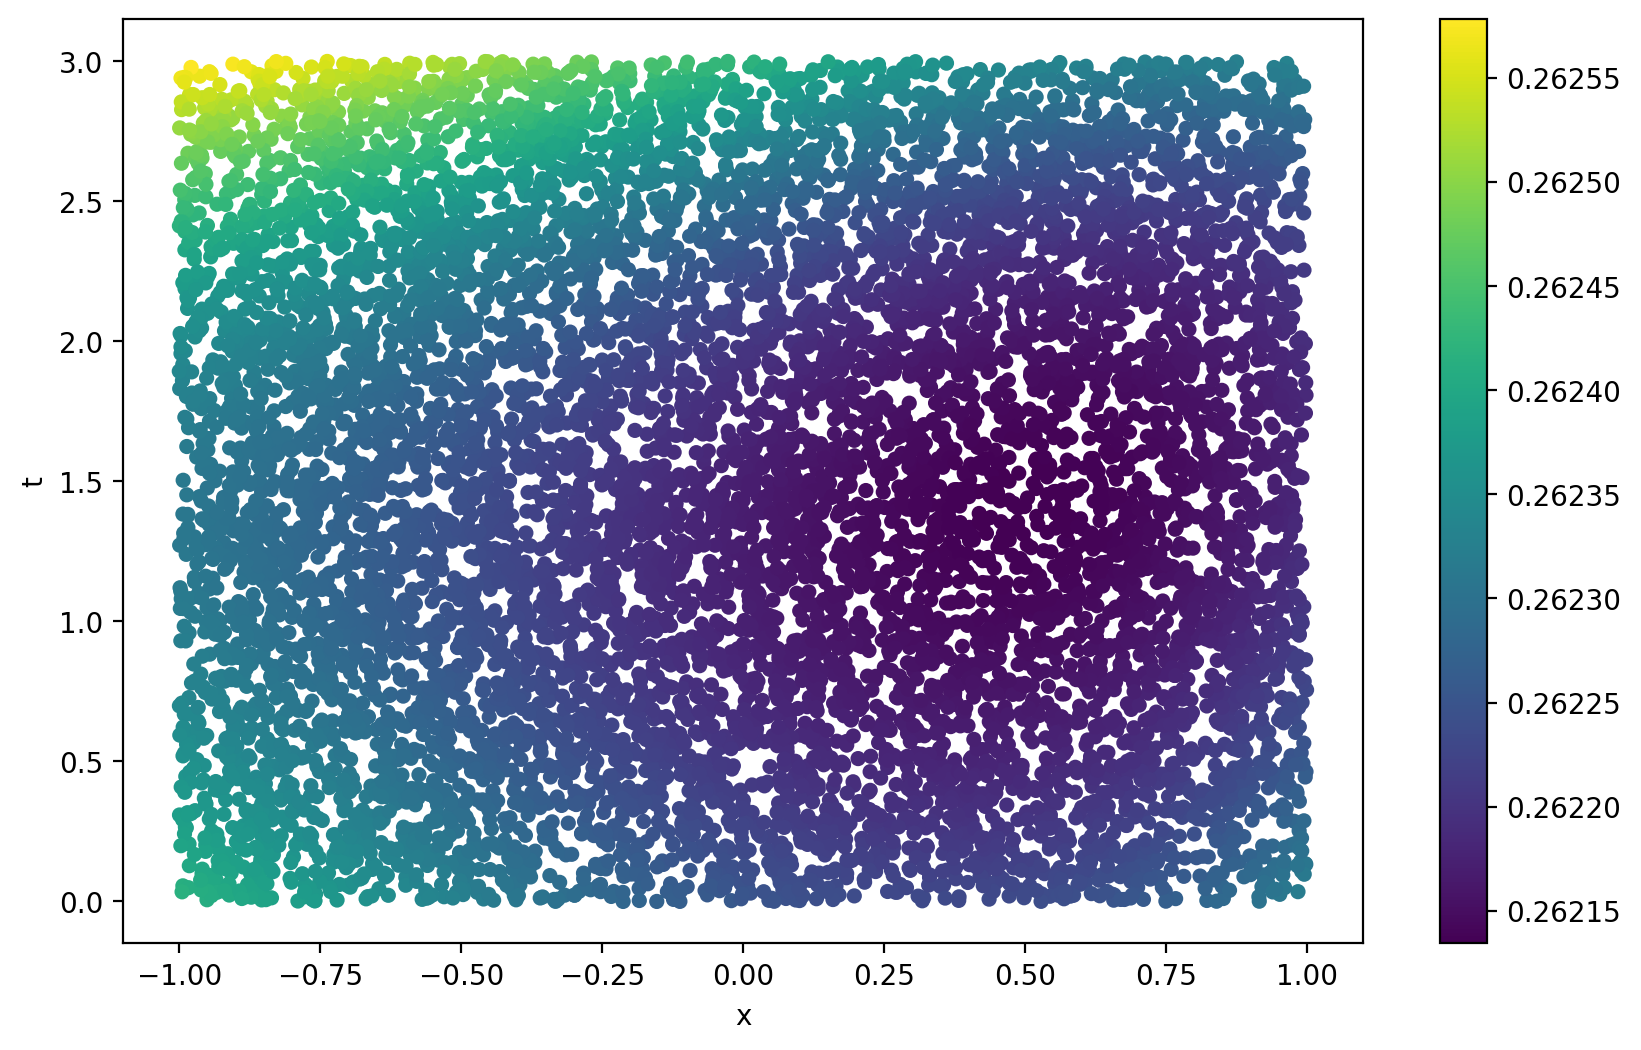

In [85]:
fig = plt.figure(figsize=(10, 6), dpi=200)
plt.scatter(features[:, 0], features[:, 1], c=pinn(features_).detach().numpy().reshape(-1), s=20, cmap='viridis')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')

plt.show()